In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
%config Completer.use_jedi = False

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import warnings

In [3]:
################################################################################
#                            ForecasterAutoreg                                 #
#                                                                              #
# This work by Joaquin Amat Rodrigo and Javier Escobar Ortiz is licensed       #
# under a Creative Commons Attribution 4.0 International License.              #
################################################################################
# coding=utf-8

from typing import Union, Dict, List, Tuple, Any, Optional
import warnings
import logging
import numpy as np
import pandas as pd
import sklearn
import sklearn.pipeline
from sklearn.base import clone
from copy import copy

import skforecast
from skforecast.ForecasterBase import ForecasterBase
from skforecast.utils import check_y
from skforecast.utils import check_exog
from skforecast.utils import preprocess_y
from skforecast.utils import preprocess_last_window
from skforecast.utils import preprocess_exog
from skforecast.utils import expand_index
from skforecast.utils import check_predict_input
from skforecast.utils import transform_dataframe
from skforecast.utils import transform_series

logging.basicConfig(
    format = '%(name)-10s %(levelname)-5s %(message)s', 
    level  = logging.INFO,
)


class ForecasterAutoreg(ForecasterBase):
    '''
    This class turns any regressor compatible with the scikit-learn API into a
    recursive autoregressive (multi-step) forecaster.
    
    Parameters
    ----------
    regressor : regressor or pipeline compatible with the scikit-learn API
        An instance of a regressor or pipeline compatible with the scikit-learn API.
        
    lags : int, list, 1d numpy ndarray, range
        Lags used as predictors. Index starts at 1, so lag 1 is equal to t-1.
            `int`: include lags from 1 to `lags` (included).
            `list`, `numpy ndarray` or `range`: include only lags present in `lags`,
            all elements must be int.

    transformer_y : transformer (preprocessor) compatible with the scikit-learn
                    preprocessing API, default `None`
        An instance of a transformer (preprocessor) compatible with the scikit-learn
        preprocessing API. The transformation is applied to `y` before training the
        forecaster.

    transformer_exog : transformer (preprocessor) compatible with the scikit-learn
                       preprocessing API, default `None`
        An instance of a transformer (preprocessor) compatible with the scikit-learn
        preprocessing API. The transformation is applied to `exog` before training the
        forecaster.

    
    Attributes
    ----------
    regressor : regressor or pipeline compatible with the scikit-learn API
        An instance of a regressor or pipeline compatible with the scikit-learn API.
        
    lags : numpy ndarray
        Lags used as predictors.

    transformer_y : transformer (preprocessor) compatible with the scikit-learn
                    preprocessing API, default `None`
        An instance of a transformer (preprocessor) compatible with the scikit-learn
        preprocessing API. The transformation is applied to `y` before training the
        forecaster.

    transformer_exog : transformer (preprocessor) compatible with the scikit-learn
                    preprocessing API, default `None`
        An instance of a transformer (preprocessor) compatible with the scikit-learn
        preprocessing API. The transformation is applied to `exog` before training the
        forecaster.
        
    max_lag : int
        Maximum value of lag included in `lags`.

    last_window : pandas Series
        Last window the forecaster has seen during trained. It stores the
        values needed to predict the next `step` right after the training data.
        
    window_size: int
        Size of the window needed to create the predictors. It is equal to
        `max_lag`.
        
    fitted: Bool
        Tag to identify if the regressor has been fitted (trained).
        
    index_type : type
        Type of index of the input used in training.
        
    index_freq : str
        Frequency of Index of the input used in training.
        
    training_range: pandas Index
        First and last values of index of the data used during training.
        
    included_exog : bool
        If the forecaster has been trained using exogenous variable/s.
        
    exog_type : type
        Type of exogenous variable/s used in training.
        
    exog_col_names : list
        Names of columns of `exog` if `exog` used in training was a pandas
        DataFrame.

    X_train_col_names : list
        Names of columns of the matrix created internally for training.
        
    in_sample_residuals: pandas Series
        Residuals of the model when predicting training data. Only stored up to
        1000 values.
        
    out_sample_residuals: pandas Series
        Residuals of the model when predicting non training data. Only stored
        up to 1000 values. Use `set_out_sample_residuals` to set values.

    creation_date: str
        Date of creation.

    fit_date: str
        Date of last fit.

    skforcast_version: str
        Version of skforecast library used to create the forecaster.
     
    '''
    
    def __init__(
        self,
        regressor,
        lags: Union[int, np.ndarray, list],
        transformer_y = None,
        transformer_exog = None,
    ) -> None:
        
        self.regressor            = regressor
        self.transformer_y       = transformer_y
        self.transformer_exog    = transformer_exog
        self.index_type           = None
        self.index_freq           = None
        self.training_range       = None
        self.last_window          = None
        self.included_exog        = False
        self.exog_type            = None
        self.exog_col_names       = None
        self.X_train_col_names    = None
        self.in_sample_residuals  = None
        self.out_sample_residuals = None
        self.fitted               = False
        self.creation_date        = pd.Timestamp.today().strftime('%Y-%m-%d %H:%M:%S')
        self.fit_date             = None
        self.skforcast_version    = skforecast.__version__
        
        if isinstance(lags, int) and lags < 1:
            raise Exception('Minimum value of lags allowed is 1.')
            
        if isinstance(lags, (list, range, np.ndarray)) and min(lags) < 1:
            raise Exception('Minimum value of lags allowed is 1.')

        if isinstance(lags, (list, np.ndarray)):
            for lag in lags:
                if not isinstance(lag, (int, np.int64, np.int32)):
                    raise Exception('Values in lags must be int.')
            
        if isinstance(lags, int):
            self.lags = np.arange(lags) + 1
        elif isinstance(lags, (list, range)):
            self.lags = np.array(lags)
        elif isinstance(lags, np.ndarray):
            self.lags = lags
        else:
            raise Exception(
                '`lags` argument must be int, 1d numpy ndarray, range or list. '
                f"Got {type(lags)}"
            )
            
        self.max_lag  = max(self.lags)
        self.window_size = self.max_lag


    def __repr__(self) -> str:
        '''
        Information displayed when a ForecasterAutoreg object is printed.
        '''

        if isinstance(self.regressor, sklearn.pipeline.Pipeline):
            name_pipe_steps = tuple(name + "__" for name in self.regressor.named_steps.keys())
            params = {key : value for key, value in self.regressor.get_params().items() \
                     if key.startswith(name_pipe_steps)}
        else:
            params = self.regressor.get_params()

        info = (
            f"{'=' * len(str(type(self)).split('.')[1])} \n"
            f"{str(type(self)).split('.')[1]} \n"
            f"{'=' * len(str(type(self)).split('.')[1])} \n"
            f"Regressor: {self.regressor} \n"
            f"Lags: {self.lags} \n"
            f"Transformer fo y: {self.transformer_y} \n"
            f"Transformer fo exog: {self.transformer_exog} \n"
            f"Window size: {self.window_size} \n"
            f"Included exogenous: {self.included_exog} \n"
            f"Type of exogenous variable: {self.exog_type} \n"
            f"Exogenous variables names: {self.exog_col_names} \n"
            f"Training range: {self.training_range.to_list() if self.fitted else None} \n"
            f"Training index type: {str(self.index_type).split('.')[-1][:-2] if self.fitted else None} \n"
            f"Training index frequency: {self.index_freq if self.fitted else None} \n"
            f"Regressor parameters: {params} \n"
            f"Creation date: {self.creation_date} \n"
            f"Last fit date: {self.fit_date} \n"
            f"Skforecast version: {self.skforcast_version} \n"
        )

        return info

    
    def _create_lags(self, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        '''       
        Transforms a 1d array into a 2d array (X) and a 1d array (y). Each row
        in X is associated with a value of y and it represents the lags that
        precede it.
        
        Notice that, the returned matrix X_data, contains the lag 1 in the first
        column, the lag 2 in the second column and so on.
        
        Parameters
        ----------        
        y : 1d numpy ndarray
            Training time series.

        Returns 
        -------
        X_data : 2d numpy ndarray, shape (samples - max(self.lags), len(self.lags))
            2d numpy array with the lagged values (predictors).
        
        y_data : 1d np.ndarray, shape (samples - max(self.lags),)
            Values of the time series related to each row of `X_data`.
            
        '''
          
        n_splits = len(y) - self.max_lag
        X_data   = np.full(shape=(n_splits, self.max_lag), fill_value=np.nan, dtype=float)
        y_data   = np.full(shape=(n_splits, 1), fill_value=np.nan, dtype=float)

        for i in range(n_splits):
            X_index = np.arange(i, self.max_lag + i)
            y_index = [self.max_lag + i]
            X_data[i, :] = y[X_index]
            y_data[i]    = y[y_index]
            
        X_data = X_data[:, -self.lags] # Only keep needed lags
        y_data = y_data.ravel()
            
        return X_data, y_data


    def create_train_X_y(
        self,
        y: pd.Series,
        exog: Optional[Union[pd.Series, pd.DataFrame]]=None
    ) -> Tuple[pd.DataFrame, pd.Series]:
        '''
        Create training matrices from univariate time series and exogenous
        variables.
        
        Parameters
        ----------        
        y : pandas Series
            Training time series.
            
        exog : pandas Series, pandas DataFrame, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and their indexes must be aligned.

        Returns 
        -------
        X_train : pandas DataFrame, shape (len(y) - self.max_lag, len(self.lags))
            Pandas DataFrame with the training values (predictors).
            
        y_train : pandas Series, shape (len(y) - self.max_lag, )
            Values (target) of the time series related to each row of `X_train`.
        
        '''
        
        check_y(y=y)
        y = transform_series(
                series            = y,
                transformer       = self.transformer_y,
                fit               = True,
                inverse_transform = False
            )
        y_values, y_index = preprocess_y(y=y)
        
        if exog is not None:
            if len(exog) != len(y):
                raise Exception(
                    "`exog` must have same number of samples as `y`."
                )
            check_exog(exog=exog)
            if isinstance(exog, pd.Series):
                exog = transform_series(
                            series            = exog,
                            transformer       = self.transformer_exog,
                            fit               = True,
                            inverse_transform = False
                        )
            else:
                exog = transform_dataframe(
                            df                = exog,
                            transformer       = self.transformer_exog,
                            fit               = True,
                            inverse_transform = False
                        )
            exog_values, exog_index = preprocess_exog(exog=exog)
            
            if not (exog_index[:len(y_index)] == y_index).all():
                raise Exception(
                ('Different index for `y` and `exog`. They must be equal '
                'to ensure the correct alignment of values.')      
                )
        
        X_train, y_train = self._create_lags(y=y_values)
        X_train_col_names = [f"lag_{i}" for i in self.lags]
        if exog is not None:
            col_names_exog = exog.columns if isinstance(exog, pd.DataFrame) else [exog.name]
            X_train_col_names.extend(col_names_exog)
            # The first `self.max_lag` positions have to be removed from exog
            # since they are not in X_train.
            X_train = np.column_stack((X_train, exog_values[self.max_lag:, ]))

        X_train = pd.DataFrame(
                    data    = X_train,
                    columns = X_train_col_names,
                    index   = y_index[self.max_lag: ]
                  )
        self.X_train_col_names = X_train_col_names
        y_train = pd.Series(
                    data  = y_train,
                    index = y_index[self.max_lag: ],
                    name  = 'y'
                 )
                        
        return X_train, y_train

        
    def fit(
        self,
        y: pd.Series,
        exog: Optional[Union[pd.Series, pd.DataFrame]]=None
    ) -> None:
        '''
        Training Forecaster.
        
        Parameters
        ----------        
        y : pandas Series
            Training time series.
            
        exog : pandas Series, pandas DataFrame, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and their indexes must be aligned so
            that y[i] is regressed on exog[i].


        Returns 
        -------
        None
        
        '''
        
        # Reset values in case the forecaster has already been fitted.
        self.index_type           = None
        self.index_freq           = None
        self.last_window          = None
        self.included_exog        = False
        self.exog_type            = None
        self.exog_col_names       = None
        self.X_train_col_names    = None
        self.in_sample_residuals  = None
        self.fitted               = False
        self.training_range       = None
        
        if exog is not None:
            self.included_exog = True
            self.exog_type = type(exog)
            self.exog_col_names = \
                 exog.columns.to_list() if isinstance(exog, pd.DataFrame) else exog.name

        X_train, y_train = self.create_train_X_y(y=y, exog=exog)

        if not str(type(self.regressor)) == "<class 'xgboost.sklearn.XGBRegressor'>":
            self.regressor.fit(X=X_train, y=y_train)
        else:
            self.regressor.fit(X=X_train.to_numpy(), y=y_train.to_numpy())
        self.fitted = True
        self.fit_date = pd.Timestamp.today().strftime('%Y-%m-%d %H:%M:%S')
        self.training_range = preprocess_y(y=y)[1][[0, -1]]
        self.index_type = type(X_train.index)
        if isinstance(X_train.index, pd.DatetimeIndex):
            self.index_freq = X_train.index.freqstr
        else: 
            self.index_freq = X_train.index.step

        if not str(type(self.regressor)) == "<class 'xgboost.sklearn.XGBRegressor'>":
            residuals = y_train - self.regressor.predict(X_train)
        else:
            residuals = y_train - self.regressor.predict(X_train.to_numpy())

        residuals = pd.Series(
                        data  = residuals,
                        index = y_train.index,
                        name  = 'in_sample_residuals'
                    )

        if len(residuals) > 1000:
            # Only up to 1000 residuals are stored
            residuals = residuals.sample(n=1000, random_state=123, replace=False)
                                                  
        self.in_sample_residuals = residuals
        
        # The last time window of training data is stored so that lags needed as
        # predictors in the first iteration of `predict()` can be calculated.
        self.last_window = y.iloc[-self.max_lag:].copy()
    

    def _recursive_predict(
        self,
        steps: int,
        last_window: np.array,
        exog: np.array
    ) -> pd.Series:
        '''
        Predict n steps ahead. It is an iterative process in which, each prediction,
        is used as a predictor for the next step.
        
        Parameters
        ----------
        steps : int
            Number of future steps predicted.
            
        last_window : numpy ndarray
            Values of the series used to create the predictors (lags) need in the 
            first iteration of prediction (t + 1).
            
        exog : numpy ndarray, pandas DataFrame
            Exogenous variable/s included as predictor/s.

        Returns 
        -------
        predictions : numpy ndarray
            Predicted values.
            
        '''

        predictions = np.full(shape=steps, fill_value=np.nan)

        for i in range(steps):
            X = last_window[-self.lags].reshape(1, -1)
            if exog is not None:
                X = np.column_stack((X, exog[i, ].reshape(1, -1)))

            with warnings.catch_warnings():
                # Suppress scikitlearn warning: "X does not have valid feature names,
                # but NoOpTransformer was fitted with feature names".
                warnings.simplefilter("ignore")
                prediction = self.regressor.predict(X)
                predictions[i] = prediction.ravel()[0]

            # Update `last_window` values. The first position is discarded and 
            # the new prediction is added at the end.
            last_window = np.append(last_window[1:], prediction)

        return predictions

            
    def predict(
        self,
        steps: int,
        last_window: Optional[pd.Series]=None,
        exog: Optional[Union[pd.Series, pd.DataFrame]]=None
    ) -> pd.Series:
        '''
        Predict n steps ahead. It is an recursive process in which, each prediction,
        is used as a predictor for the next step.
        
        Parameters
        ----------
        steps : int
            Number of future steps predicted.
            
        last_window : pandas Series, default `None`
            Values of the series used to create the predictors (lags) need in the 
            first iteration of prediction (t + 1).
    
            If `last_window = None`, the values stored in` self.last_window` are
            used to calculate the initial predictors, and the predictions start
            right after training data.
            
        exog : pandas Series, pandas DataFrame, default `None`
            Exogenous variable/s included as predictor/s.

        Returns 
        -------
        predictions : pandas Series
            Predicted values.
            
        '''

        check_predict_input(
            forecaster_type = type(self),
            steps           = steps,
            fitted          = self.fitted,
            included_exog   = self.included_exog,
            index_type      = self.index_type,
            index_freq      = self.index_freq,
            window_size     = self.window_size,
            last_window     = last_window,
            exog            = exog,
            exog_type       = self.exog_type,
            exog_col_names  = self.exog_col_names,
            max_steps       = None,
        ) 

        if exog is not None:
            if isinstance(exog, pd.DataFrame):
                exog = transform_dataframe(
                            df                = exog,
                            transformer       = self.transformer_exog,
                            fit               = False,
                            inverse_transform = False
                       )
                exog_values, _ = preprocess_exog(
                                    exog = exog.iloc[:steps, :]
                                 )
            else:
                exog = transform_series(
                            series            = exog,
                            transformer       = self.transformer_exog,
                            fit               = False,
                            inverse_transform = False
                       )
                exog_values, _ = preprocess_exog(
                                    exog = exog.iloc[:steps, ]
                                 )
        else:
            exog_values = None
            
        if last_window is not None:
            last_window = transform_series(
                                series            = last_window,
                                transformer       = self.transformer_y,
                                fit               = False,
                                inverse_transform = False
                          )
            last_window_values, last_window_index = preprocess_last_window(
                                                        last_window = last_window
                                                    )  
        else:
            last_window = transform_series(
                                series            = self.last_window.copy(),
                                transformer       = self.transformer_y,
                                fit               = False,
                                inverse_transform = False
                          )
            last_window_values, last_window_index = preprocess_last_window(
                                                        last_window = last_window
                                                    )
            
        predictions = self._recursive_predict(
                        steps       = steps,
                        last_window = copy(last_window_values),
                        exog        = copy(exog_values)
                      )

        predictions = pd.Series(
                        data  = predictions,
                        index = expand_index(
                                    index = last_window_index,
                                    steps = steps
                                ),
                        name = 'pred'
                      )

        predictions = transform_series(
                        series            = predictions,
                        transformer       = self.transformer_y,
                        fit               = False,
                        inverse_transform = True
                      )

        return predictions
    
    
    def _estimate_boot_interval(
        self,
        steps: int,
        last_window: Optional[np.ndarray]=None,
        exog: Optional[np.ndarray]=None,
        interval: list=[5, 95],
        n_boot: int=500,
        random_state: int=123,
        in_sample_residuals: bool=True
    ) -> np.ndarray:
        '''
        Iterative process in which, each prediction, is used as a predictor
        for the next step and bootstrapping is used to estimate prediction
        intervals. This method only returns prediction intervals.
        See predict_intervals() to calculate both, predictions and intervals.
        
        Parameters
        ----------   
        steps : int
            Number of future steps predicted.
            
        last_window : 1d numpy ndarray shape (, max_lag), default `None`
            Values of the series used to create the predictors (lags) needed in the 
            first iteration of prediction (t + 1).
    
            If `last_window = `None`, the values stored in` self.last_window` are
            used to calculate the initial predictors, and the predictions start
            right after training data.
            
        exog : numpy ndarray, default `None`
            Exogenous variable/s included as predictor/s.
            
        n_boot: int, default `500`
            Number of bootstrapping iterations used to estimate prediction
            intervals.

        random_state: int
            Sets a seed to the random generator, so that boot intervals are always 
            deterministic.
            
        interval: list, default `[5, 95]`
            Confidence of the prediction interval estimated. Sequence of percentiles
            to compute, which must be between 0 and 100 inclusive.
            
        in_sample_residuals: bool, default `True`
            If `True`, residuals from the training data are used as proxy of
            prediction error to create prediction intervals. If `False`, out of
            sample residuals are used. In the latter case, the user should have
            calculated and stored the residuals within the forecaster (see
            `set_out_sample_residuals()`).
            

        Returns 
        -------
        prediction_interval : numpy ndarray, shape (steps, 2)
            Interval estimated for each prediction by bootstrapping:
                first column = lower bound of the interval.
                second column= upper bound interval of the interval.

        Notes
        -----
        More information about prediction intervals in forecasting:
        https://otexts.com/fpp2/prediction-intervals.html
        Forecasting: Principles and Practice (2nd ed) Rob J Hyndman and
        George Athanasopoulos.
            
        '''
        
        if last_window is None:
            last_window = self.last_window.values

        boot_predictions = np.full(
                                shape      = (steps, n_boot),
                                fill_value = np.nan,
                                dtype      = float
                           )
        rng = np.random.default_rng(seed=random_state)
        seeds = rng.integers(low=0, high=10000, size=n_boot)

        for i in range(n_boot):
            # In each bootstraping iteration the initial last_window and exog 
            # need to be restored.
            last_window_boot = last_window.copy()
            if exog is not None:
                exog_boot = exog.copy()
            else:
                exog_boot = None
 
            if in_sample_residuals:
                residuals = self.in_sample_residuals
            else:
                residuals = self.out_sample_residuals

            rng = np.random.default_rng(seed=seeds[i])
            sample_residuals = rng.choice(
                                    a       = residuals,
                                    size    = steps,
                                    replace = True
                               )

            for step in range(steps):
                prediction = self._recursive_predict(
                                steps       = 1,
                                last_window = last_window_boot,
                                exog        = exog_boot 
                             )
                
                prediction_with_residual  = prediction + sample_residuals[step]
                boot_predictions[step, i] = prediction_with_residual

                last_window_boot = np.append(
                                    last_window_boot[1:],
                                    prediction_with_residual
                                   )
                
                if exog is not None:
                    exog_boot = exog_boot[1:]
                            
        prediction_interval = np.percentile(boot_predictions, q=interval, axis=1)
        prediction_interval = prediction_interval.transpose()
        
        return prediction_interval
    
        
    def predict_interval(
        self,
        steps: int,
        last_window: Optional[pd.Series]=None,
        exog: Optional[Union[pd.Series, pd.DataFrame]]=None,
        interval: list=[5, 95],
        n_boot: int=500,
        random_state: int=123,
        in_sample_residuals: bool=True
    ) -> pd.DataFrame:
        '''
        Iterative process in which, each prediction, is used as a predictor
        for the next step and bootstrapping is used to estimate prediction
        intervals. Both, predictions and intervals, are returned.
        
        Parameters
        ---------- 
        steps : int
            Number of future steps predicted.
            
        last_window : pandas Series, default `None`
            Values of the series used to create the predictors (lags) needed in the 
            first iteration of prediction (t + 1).
    
            If `last_window = None`, the values stored in` self.last_window` are
            used to calculate the initial predictors, and the predictions start
            right after training data.
            
        exog : pandas Series, pandas DataFrame, default `None`
            Exogenous variable/s included as predictor/s.
            
        interval: list, default `[5, 95]`
            Confidence of the prediction interval estimated. Sequence of percentiles
            to compute, which must be between 0 and 100 inclusive.
            
        n_boot: int, default `500`
            Number of bootstrapping iterations used to estimate prediction
            intervals.

        random_state: int, default 123
            Sets a seed to the random generator, so that boot intervals are always 
            deterministic.
            
        in_sample_residuals: bool, default `True`
            If `True`, residuals from the training data are used as proxy of
            prediction error to create prediction intervals. If `False`, out of
            sample residuals are used. In the latter case, the user should have
            calculated and stored the residuals within the forecaster (see
            `set_out_sample_residuals()`).

        Returns 
        -------
        predictions : pandas DataFrame
            Values predicted by the forecaster and their estimated interval:
                column pred = predictions.
                column lower_bound = lower bound of the interval.
                column upper_bound = upper bound interval of the interval.

        Notes
        -----
        More information about prediction intervals in forecasting:
        https://otexts.com/fpp2/prediction-intervals.html
        Forecasting: Principles and Practice (2nd ed) Rob J Hyndman and
        George Athanasopoulos.
            
        '''
        
        check_predict_input(
            forecaster_type = type(self),
            steps           = steps,
            fitted          = self.fitted,
            included_exog   = self.included_exog,
            index_type      = self.index_type,
            index_freq      = self.index_freq,
            window_size     = self.window_size,
            last_window     = last_window,
            exog            = exog,
            exog_type       = self.exog_type,
            exog_col_names  = self.exog_col_names,
            max_steps       = None,
        ) 
        
        if exog is not None:
            if isinstance(exog, pd.DataFrame):
                exog = transform_dataframe(
                            df                = exog,
                            transformer       = self.transformer_exog,
                            fit               = False,
                            inverse_transform = False
                       )
                exog_values, _ = preprocess_exog(
                                    exog = exog.iloc[:steps, :]
                                 )
            else:
                exog = transform_series(
                            series            = exog,
                            transformer       = self.transformer_exog,
                            fit               = False,
                            inverse_transform = False
                       ) 
                exog_values, _ = preprocess_exog(
                                    exog = exog.iloc[:steps, ]
                                 )
        else:
            exog_values = None
            
        if last_window is not None:
            last_window = transform_series(
                                series            = last_window,
                                transformer       = self.transformer_y,
                                fit               = False,
                                inverse_transform = False
                          )
            last_window_values, last_window_index = preprocess_last_window(
                                                        last_window = last_window
                                                    )  
        else:
            last_window = transform_series(
                                series            = self.last_window.copy(),
                                transformer       = self.transformer_y,
                                fit               = False,
                                inverse_transform = False
                          )
            last_window_values, last_window_index = preprocess_last_window(
                                                        last_window = last_window
                                                    )
        
        # Since during predict() `last_window_values` and `exog_values` are modified,
        # the originals are stored to be used later.
        last_window_values_original = last_window_values.copy()
        if exog is not None:
            exog_values_original = exog_values.copy()
        else:
            exog_values_original = None
        
        predictions = self._recursive_predict(
                            steps       = steps,
                            last_window = last_window_values,
                            exog        = exog_values
                      )

        predictions_interval = self._estimate_boot_interval(
                                    steps       = steps,
                                    last_window = copy(last_window_values_original),
                                    exog        = copy(exog_values_original),
                                    interval    = interval,
                                    n_boot      = n_boot,
                                    random_state = random_state,
                                    in_sample_residuals = in_sample_residuals
                               )
        
        predictions = np.column_stack((predictions, predictions_interval))

        predictions = pd.DataFrame(
                        data = predictions,
                        index = expand_index(
                                    index = last_window_index,
                                    steps = steps
                                ),
                        columns = ['pred', 'lower_bound', 'upper_bound']
                      )

        predictions = transform_dataframe(
                            df                = predictions,
                            transformer       = self.transformer_y,
                            fit               = False,
                            inverse_transform = True
                       )

        return predictions

    
    def set_params(self, **params: dict) -> None:
        '''
        Set new values to the parameters of the scikit learn model stored in the
        ForecasterAutoreg.
        
        Parameters
        ----------
        params : dict
            Parameters values.

        Returns 
        -------
        self
        
        '''
        self.regressor = clone(self.regressor)
        self.regressor.set_params(**params)
        
        
    def set_lags(self, lags: Union[int, list, np.ndarray, range]) -> None:
        '''      
        Set new value to the attribute `lags`.
        Attributes `max_lag` and `window_size` are also updated.
        
        Parameters
        ----------
        lags : int, list, 1D np.array, range
            Lags used as predictors. Index starts at 1, so lag 1 is equal to t-1.
                `int`: include lags from 1 to `lags`.
                `list` or `np.array`: include only lags present in `lags`.

        Returns 
        -------
        None
        
        '''
        
        if isinstance(lags, int) and lags < 1:
            raise Exception('min value of lags allowed is 1')
            
        if isinstance(lags, (list, range, np.ndarray)) and min(lags) < 1:
            raise Exception('min value of lags allowed is 1')
            
        if isinstance(lags, int):
            self.lags = np.arange(lags) + 1
        elif isinstance(lags, (list, range)):
            self.lags = np.array(lags)
        elif isinstance(lags, np.ndarray):
            self.lags = lags
        else:
            raise Exception(
                f"`lags` argument must be `int`, `1D np.ndarray`, `range` or `list`. "
                f"Got {type(lags)}"
            )
            
        self.max_lag  = max(self.lags)
        self.window_size = max(self.lags)
        
        
    def set_out_sample_residuals(
        self,
        residuals: pd.Series,
        append: bool=True,
        transform=False
    )-> None:
        '''
        Set new values to the attribute `out_sample_residuals`. Out of sample
        residuals are meant to be calculated using observations that did not
        participate in the training process. If a transformer is used on `y` during
        the training, new residuals must be transformed (`transform=True`).
        
        Parameters
        ----------
        residuals : pd.Series
            Values of residuals. If len(residuals) > 1000, only a random sample
            of 1000 values are stored.
            
        append : bool, default `True`
            If `True`, new residuals are added to the once already stored in the
            attribute `out_sample_residuals`. Once the limit of 1000 values is
            reached, no more values are appended. If False, `out_sample_residuals`
            is overwritten with the new residuals.

        transform : bool, default `True`
            If `True`, new residuals are transformed using self.transformer_y.
            
        Returns 
        -------
        self
        '''

        if not isinstance(residuals, pd.Series):
            raise Exception(
                f"`residuals` argument must be `pd.Series`. Got {type(residuals)}"
            )

        if transform and self.transformer_y is not None:
            residuals = transform_series(
                            series            = residuals,
                          ValueError: Specifying the columns using strings is only supported for pandas DataFrames  transformer       = self.transformer_y,
                            fit               = False,
                            inverse_transform = False
                        ) 

        if len(residuals) > 1000:
            rng = np.random.default_rng(seed=123)
            residuals = rng.choice(a=residuals, size=1000, replace=False)
            residuals = pd.Series(residuals)   
      
        if append and self.out_sample_residuals is not None:
            free_space = max(0, 1000 - len(self.out_sample_residuals))
            if len(residuals) < free_space:
                residuals = np.hstack((
                                self.out_sample_residuals,
                                residuals
                            ))
            else:
                residuals = np.hstack((
                                self.out_sample_residuals,
                                residuals[:free_space]
                            ))

        self.out_sample_residuals = pd.Series(residuals)

    
    def get_feature_importance(self) -> pd.DataFrame:
        '''      
        Return feature importance of the regressor stored in the
        forecaster. Only valid when regressor stores internally the feature
        importance in the attribute `feature_importances_` or `coef_`.

        Parameters
        ----------
        self

        Returns
        -------
        feature_importance : pandas DataFrame
            Feature importance associated with each predictor.
        '''

        if isinstance(self.regressor, sklearn.pipeline.Pipeline):
            estimator = self.regressor[-1]
        else:
            estimator = self.regressor

        try:
            feature_importance = pd.DataFrame({
                                    'feature': self.X_train_col_names,
                                    'importance' : estimator.feature_importances_
                                })
        except:   
            try:
                feature_importance = pd.DataFrame({
                                        'feature': self.X_train_col_names,
                                        'importance' : estimator.coef_
                                    })
            except:
                warnings.warn(
                    f"Impossible to access feature importance for regressor of type {type(estimator)}. "
                    f"This method is only valid when the regressor stores internally "
                    f"the feature importance in the attribute `feature_importances_` "
                    f"or `coef_`."
                )

                feature_importance = None

        return feature_importance

# Data

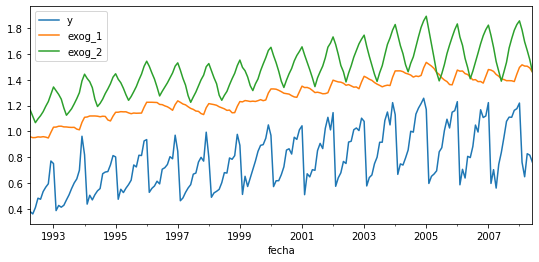

In [4]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()
data['exog_3'] = (["A"] * int(len(data)/2)) + (["B"] * (int(len(data)/2) +1))

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [5]:
transformer_exog = ColumnTransformer(
                   [('scale', StandardScaler(), ['exog_1']),
                    ('scale1', StandardScaler(), ['exog_2']),
                    ('onehot', OneHotEncoder(), ['exog_3'])],
                remainder='passthrough',
                verbose_feature_names_out=False)

forecaster = ForecasterAutoreg(lags=10, regressor=LinearRegression(), transformer_exog=transformer_exog)

forecaster.fit(y=data.y, exog=data[['exog_1', 'exog_2', 'exog_3']])

forecaster.predict(steps=4, exog=data[['exog_1', 'exog_2', 'exog_3']])

2008-07-01    1.896940
2008-08-01   -0.114746
2008-09-01    0.086815
2008-10-01    0.744975
Freq: MS, Name: pred, dtype: float64

In [6]:
forecaster.predict_interval(steps=4, exog=data[['exog_1', 'exog_2', 'exog_3']], n_boot=10)

,pred,lower_bound,upper_bound
2008-07-01,1.896940,1.896940,1.896940
2008-08-01,-0.114746,-0.114746,-0.114746
2008-09-01,0.086815,0.086815,0.086815
2008-10-01,0.744975,0.744975,0.744975


In [8]:
data_train

,y,exog_1,exog_2,exog_3
fecha,,,,
1992-04-01,0.379808,0.958792,1.166029,A
1992-05-01,0.361801,0.951993,1.117859,A
1992-06-01,0.410534,0.952955,1.067942,A
1992-07-01,0.483389,0.958078,1.097376,A
1992-08-01,0.475463,0.956370,1.122199,A
...,...,...,...,...
2005-02-01,0.597639,1.520544,1.784523,B
2005-03-01,0.652590,1.506290,1.678839,B
2005-04-01,0.670505,1.487660,1.569732,B


In [7]:
# Create and fit forecaster
# ==============================================================================
forecaster.fit(y=data_train.y, exog=data_train.exog_1)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test.exog_1)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [ ]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor= make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'randomforestregressor__n_estimators': [50, 100],
              'randomforestregressor__max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train.y,
                        exog        = data_train.exog_1,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size = int(len(data_train)*0.5),
                        return_best = False,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid.head(4)

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:06<00:00,  2.18s/it]


,lags,params,metric,randomforestregressor__max_depth,randomforestregressor__n_estimators
8,"[1, 2, 3, 20]","{'randomforestregressor__max_depth': 5, 'rando...",0.054931,5,50
10,"[1, 2, 3, 20]","{'randomforestregressor__max_depth': 10, 'rand...",0.057604,10,50
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'randomforestregressor__max_depth': 5, 'rando...",0.059934,5,50
9,"[1, 2, 3, 20]","{'randomforestregressor__max_depth': 5, 'rando...",0.060493,5,100


In [ ]:
# Backtesting
# ==============================================================================
steps = 36
n_backtest = 36 * 3 + 1
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoreg(regressor=LinearRegression(), lags=10)

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data.y,
    exog       = data.exog_1,
    initial_train_size = len(data_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metrica)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 1999-06-01 00:00:00 -- 2002-05-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2002-06-01 00:00:00 -- 2005-05-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2005-06-01 00:00:00 -- 2008-05-01 00:00:00
Data partition in fold: 3
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2008-06-01 00:00:00 -- 2008-06-01 00:00:00

[6.21996921e-30]


In [ ]:
# Verificar predicciones de backtesting
forecaster.fit(y=data_train.y, exog=data_train.exog_1)
predictions_1 = forecaster.predict(steps=steps, exog=data_test.exog_1[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps], exog=data_test.exog_1[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2], exog=data_test.exog_1[steps*2:steps*3])
predictions_4 = forecaster.predict(steps=1, last_window=data_test.y[steps*2:steps*3], exog=data_test.exog_1[steps*3:steps*4])
np.allclose(predicciones_backtest['pred'], np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4]))

True

# ForecasterAutoreg with multiple exogenous variables

In [ ]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [ ]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 2
             )

forecaster.fit(y=data_train.y, exog=data_train[['exog_1', 'exog_2']])

forecaster

ForecasterAutoreg 
Regressor: LinearRegression() 
Lags: [1 2] 
Window size: 2 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['exog_1', 'exog_2'] 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False} 
Creation date: 2022-01-02 13:28:53 
Last fit date: 2022-01-02 13:28:53 
Skforecast version: 0.4.2 

Test error (mse): 0.030285034610348982


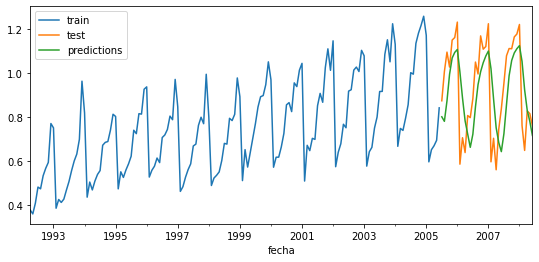

In [ ]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test[['exog_1', 'exog_2']])

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [ ]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['y'],
                        exog        = data_train[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size    = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:06<00:00,  2.24s/it]

Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 0.04157249499273814



,lags,params,metric,max_depth,n_estimators
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.041572,5,50
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.042374,10,50
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.047357,5,100
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.047655,10,100
3,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",0.049627,10,100
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.050294,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.051669,5,50
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.052149,5,50
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.052404,5,100
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.052786,10,50


# Unit Testing

In [ ]:
# Unit test __init__
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression

def test_init_lags_when_integer():
    '''
    Test creation of attribute lags when integer is passed.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=10)
    assert (forecaster.lags == np.arange(10) + 1).all()
    
def test_init_lags_when_list():
    '''
    Test creation of attribute lags when list is passed.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=[1, 2, 3])
    assert (forecaster.lags == np.array([1, 2, 3])).all()
    
def test_init_lags_when_range():
    '''
    Test creation of attribute lags when range is passed.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=range(1, 4))
    assert (forecaster.lags == np.array(range(1, 4))).all()
    
def test_init_lags_when_numpy_arange():
    '''
    Test creation of attribute lags when numpy arange is passed.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=np.arange(1, 10))
    assert (forecaster.lags == np.arange(1, 10)).all()

def test_init_exception_when_lags_is_int_lower_than_1():
    '''
    Test exception is raised when lags is initialized with int lower than 1.
    '''
    with pytest.raises(Exception):
        ForecasterAutoreg(LinearRegression(), lags=-10)
        
def test_init_exception_when_lags_has_values_lower_than_1():
    '''
    Test exception is raised when lags is initialized with any value lower than 1.
    '''
    for lags in [[0, 1], range(0, 2), np.arange(0, 2)]:
        with pytest.raises(Exception):
            ForecasterAutoreg(LinearRegression(), lags=lags)

        
test_init_lags_when_integer()
test_init_lags_when_list() 
test_init_lags_when_range()
test_init_lags_when_numpy_arange()
test_init_exception_when_lags_is_int_lower_than_1()  
test_init_exception_when_lags_has_values_lower_than_1()

In [ ]:
# Unit test _create_lags
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression


def test_create_lags_output():
    '''
    Test matrix of lags is created properly when langs=3 and y=np.arange(10).
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    results = forecaster._create_lags(y=np.arange(10))
    expected = (np.array([[2., 1., 0.],
                         [3., 2., 1.],
                         [4., 3., 2.],
                         [5., 4., 3.],
                         [6., 5., 4.],
                         [7., 6., 5.],
                         [8., 7., 6.]]),
               np.array([3., 4., 5., 6., 7., 8., 9.]))

    assert (results[0] == expected[0]).all()
    assert (results[1] == expected[1]).all()
    
    
def test_create_lags_exception_when_len_of_y_is_lower_than_maximum_lag():
    '''
    Test exception is raised when lenght of y is lower than maximum lag included
    in the forecaster.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=10)
    with pytest.raises(Exception):
        forecaster._create_lags(y=np.arange(5))

test_create_lags_output()
test_create_lags_exception_when_len_of_y_is_lower_than_maximum_lag()

In [ ]:
# Unit test create_train_X_y
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression


def test_create_train_X_y_output_when_y_is_series_10_and_exog_is_None():
    '''
    Test the output of create_train_X_y when y=pd.Series(np.arange(10)) and 
    exog is None.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=5)
    results = forecaster.create_train_X_y(y=pd.Series(np.arange(10)))
    expected = (pd.DataFrame(
                    data = np.array([[4, 3, 2, 1, 0],
                                    [5, 4, 3, 2, 1],
                                    [6, 5, 4, 3, 2],
                                    [7, 6, 5, 4, 3],
                                    [8, 7, 6, 5, 4]]),
                    index   = np.array([5, 6, 7, 8, 9]),
                    columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
                ),
                pd.Series(
                    np.array([5, 6, 7, 8, 9]),
                    index = np.array([5, 6, 7, 8, 9]))
               )     

    assert (results[0] == expected[0]).all().all()
    assert (results[1] == expected[1]).all()


def test_create_train_X_y_output_when_y_is_series_10_and_exog_is_series():
    '''
    Test the output of create_train_X_y when y=pd.Series(np.arange(10)) and 
    exog is a pandas series
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=5)
    results = forecaster.create_train_X_y(
                y = pd.Series(np.arange(10)),
                exog =  pd.Series(np.arange(100, 110), name='exog')
              )
    expected = (pd.DataFrame(
                    data = np.array([[4, 3, 2, 1, 0, 105],
                                    [5, 4, 3, 2, 1, 106],
                                    [6, 5, 4, 3, 2, 107],
                                    [7, 6, 5, 4, 3, 108],
                                    [8, 7, 6, 5, 4, 109]]),
                    index   = np.array([5, 6, 7, 8, 9]),
                    columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'exog']
                ),
                pd.Series(
                    np.array([5, 6, 7, 8, 9]),
                    index = np.array([5, 6, 7, 8, 9]))
               )       

    assert (results[0] == expected[0]).all().all()
    assert (results[1] == expected[1]).all()

def test_create_train_X_y_output_when_y_is_series_10_and_exog_is_daraframe():
    '''
    Test the output of create_train_X_y when y=pd.Series(np.arange(10)) and 
    exog is a pandas dataframe with two columns.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=5)
    results = forecaster.create_train_X_y(
                y = pd.Series(np.arange(10)),
                exog = pd.DataFrame({
                            'exog_1' : np.arange(100, 110),
                            'exog_2' : np.arange(1000, 1010)
                })
              )
        
    expected = (pd.DataFrame(
                    data = np.array([[4, 3, 2, 1, 0, 105, 1005],
                                  [5, 4, 3, 2, 1, 106, 1006],
                                  [6, 5, 4, 3, 2, 107, 1007],
                                  [7, 6, 5, 4, 3, 108, 1008],
                                  [8, 7, 6, 5, 4, 109, 1009]]),
                    index   = np.array([5, 6, 7, 8, 9]),
                    columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'exog_1', 'exog_2']
                ),
                pd.Series(
                    np.array([5, 6, 7, 8, 9]),
                    index = np.array([5, 6, 7, 8, 9])
                )
               )        

    assert (results[0] == expected[0]).all().all()
    assert (results[1] == expected[1]).all()

def test_create_train_X_y_exception_when_y_and_exog_have_different_lenght():
    '''
    Test exception is raised when lenght of y and lenght of exog are different.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=5)
    with pytest.raises(Exception):
        forecaster.fit(y=pd.Series(np.arange(50)), exog=pd.Series(np.arange(10)))
    with pytest.raises(Exception):
        forecaster.fit(y=pd.Series(np.arange(10)), exog=pd.Series(np.arange(50)))
    with pytest.raises(Exception):
        forecaster.fit(
            y=pd.Series(np.arange(10)),
            exog=pd.DataFrame(np.arange(50).reshape(25,2))
        )
        
def test_create_train_X_y_exception_when_y_and_exog_have_different_index():
    '''
    Test exception is raised when y and exog have diferent index.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=5)
    with pytest.raises(Exception):
        forecaster.fit(
            y=pd.Series(np.arange(50)),
            exog=pd.Series(np.arange(10), index=np.arange(100, 110))
        )
           
test_create_train_X_y_output_when_y_is_series_10_and_exog_is_None()
test_create_train_X_y_output_when_y_is_series_10_and_exog_is_series()
test_create_train_X_y_output_when_y_is_series_10_and_exog_is_daraframe()
test_create_train_X_y_exception_when_y_and_exog_have_different_lenght()

/home/ximo/anaconda3/lib/python3.7/site-packages/skforecast/utils/utils.py:344: UserWarning: `exog` has DatetimeIndex index but no frequency. The index is overwritten with a RangeIndex.
  ('`exog` has DatetimeIndex index but no frequency. The index is '


In [ ]:
# Unit test fit
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression

        
def test_fit_last_window_stored():
    '''
    Test that values of last window are stored after fitting.
    '''    
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(50)))
    expected = pd.Series(np.array([47, 48, 49]), index=[47, 48, 49])
    assert (forecaster.last_window == expected).all()
    
    
def test_fit_in_sample_residuals_stored():
    '''
    Test that values of in_sample_residuals are stored after fitting.
    '''    
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(5)))
    expected = np.array([0, 0])
    results = forecaster.in_sample_residuals  
    assert results.values == approx(expected)
    
test_fit_last_window_stored()
test_fit_in_sample_residuals_stored()

In [ ]:
# Unit test _recursive_predict
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression

def test_recursive_predict_output_when_regresor_is_LinearRegression():
    '''
    Test _recursive_predict output when using LinearRegression as regressor.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(50)))
    predictions = forecaster._recursive_predict(
                    steps = 5,
                    last_window = forecaster.last_window.values,
                    exog = None
                  )
    expected = np.array([50., 51., 52., 53., 54.])
    assert (predictions == approx(expected))
    
test_recursive_predict_output_when_regresor_is_LinearRegression()

In [ ]:
# Unit test predict
# ==============================================================================
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression

        
def test_predict_output_when_regresor_is_LinearRegression():
    '''
    Test predict output when using LinearRegression as regressor.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(50)))
    predictions = forecaster.predict(steps=5)
    expected = pd.Series(
                data = np.array([50., 51., 52., 53., 54.]),
                index = pd.RangeIndex(start=50, stop=55, step=1),
                name = 'pred'
               )
    pd.testing.assert_series_equal(predictions, expected)
    
test_predict_output_when_regresor_is_LinearRegression()

In [ ]:
# Unit test get_coef
# ==============================================================================
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


def test_output_get_coef_when_regressor_is_LinearRegression():
    '''
    Test output of get_coef when regressor is LinearRegression with lags=3
    and it is trained with y=pd.Series(np.arange(5)).
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(5)))
    expected = pd.DataFrame({
                    'feature': ['lag_1', 'lag_2', 'lag_3'],
                    'coef': np.array([0.33333333, 0.33333333, 0.33333333])
                })
    results = forecaster.get_coef()
    assert (results['feature'] == expected['feature']).all()
    assert results['coef'].values == approx(expected['coef'].values)
    
def test_output_get_coef_when_regressor_is_RandomForest():
    '''
    '''
    forecaster = ForecasterAutoreg(RandomForestRegressor(n_estimators=1, max_depth=2), lags=3)
    forecaster.fit(y=pd.Series(np.arange(5)))
    expected = None
    results = forecaster.get_coef()
    assert results is expected
    
test_output_get_coef_when_regressor_is_LinearRegression()
test_output_get_coef_when_regressor_is_RandomForest()

/home/ximo/anaconda3/lib/python3.7/site-packages/skforecast/ForecasterAutoreg/ForecasterAutoreg.py:905: UserWarning: Impossible to access feature coefficients for regressor of type <class 'sklearn.ensemble._forest.RandomForestRegressor'>. This method is only valid when the regressor stores internally  the coefficients in the attribute `coef_`.
  f"Impossible to access feature coefficients for regressor of type {type(estimator)}. "


In [ ]:
# Unit test get_feature_importance
# ==============================================================================
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

def test_output_get_feature_importance_when_regressor_is_RandomForest():
    forecaster = ForecasterAutoreg(RandomForestRegressor(n_estimators=1, max_depth=2, random_state=123), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    expected = pd.DataFrame({
                    'feature': ['lag_1', 'lag_2', 'lag_3'],
                    'importance': np.array([0.94766355, 0., 0.05233645])
                })
    results = forecaster.get_feature_importance()
    assert (results['feature'] == expected['feature']).all()
    assert results['importance'].values == approx(expected['importance'].values)
    
    
def test_output_get_feature_importance_when_regressor_is_linear_model():
    forecaster = ForecasterAutoreg(Lasso(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(5)))
    expected = None
    results = forecaster.get_feature_importance()
    assert results is expected
    
test_output_get_feature_importance_when_regressor_is_RandomForest()
test_output_get_feature_importance_when_regressor_is_linear_model()

/home/ximo/anaconda3/lib/python3.7/site-packages/skforecast/ForecasterAutoreg/ForecasterAutoreg.py:943: UserWarning: Impossible to access feature importance for regressor of type <class 'sklearn.linear_model._coordinate_descent.Lasso'>. This method is only valid when the regressor stores internally  the feature importance in the attribute `feature_importances_`.
  f"Impossible to access feature importance for regressor of type {type(estimator)}. "


In [ ]:
# Unit test set_lags
# ==============================================================================
import pytest
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression


def test_set_lags_exception_when_lags_argument_is_int_lower_than_1():
    '''
    Test exception is raised when lags argument is lower than 1.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    with pytest.raises(Exception):
        forecaster.set_lags(lags=-10)

def test_set_lags_exception_when_lags_argument_has_any_value_lower_than_1():
    '''
    Test exception is raised when lags argument has at least one value
    lower than 1.
    '''
    
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    with pytest.raises(Exception):
        forecaster.set_lags(lags=range(0, 4))        
        
def test_set_lags_when_lags_argument_is_int():
    '''
    Test how lags and max_lag attributes change when lags argument is integer
    positive (5).
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.set_lags(lags=5)
    assert (forecaster.lags == np.array([1, 2, 3, 4, 5])).all()
    assert forecaster.max_lag == 5
    
def test_set_lags_when_lags_argument_is_list():
    '''
    Test how lags and max_lag attributes change when lags argument is a list
    of positive integers.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.set_lags(lags=[1,2,3])
    assert (forecaster.lags == np.array([1, 2, 3])).all()
    assert forecaster.max_lag == 3
    
def test_set_lags_when_lags_argument_is_1d_numpy_array():
    '''
    Test how lags and max_lag attributes change when lags argument is 1d numpy
    array of positive integers.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.set_lags(lags=np.array([1,2,3]))
    assert (forecaster.lags == np.array([1, 2, 3])).all()
    assert forecaster.max_lag == 3
    
test_set_lags_exception_when_lags_argument_is_int_lower_than_1()
test_set_lags_exception_when_lags_argument_has_any_value_lower_than_1()
test_set_lags_when_lags_argument_is_int()
test_set_lags_when_lags_argument_is_list()
test_set_lags_when_lags_argument_is_1d_numpy_array()

In [ ]:
# Unit test set_params
# ==============================================================================
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression


def test_set_params():
    
    forecaster = ForecasterAutoreg(LinearRegression(fit_intercept=True), lags=3)
    new_paramns = {'fit_intercept': False}
    forecaster.set_params(**new_paramns)
    expected = {'copy_X': True,
                 'fit_intercept': False,
                 'n_jobs': None,
                 'normalize': 'deprecated',
                 'positive': False
                }
    results = forecaster.regressor.get_params()
    assert results == expected
    
test_set_params()

In [ ]:
def test_set_params():
    
    forecaster = ForecasterAutoreg(LinearRegression(fit_intercept=True), lags=3)
    new_params = {'fit_intercept': False}
    forecaster.set_params(**new_params)
    expected = {'copy_X': True,
                 'fit_intercept': False,
                 'n_jobs': None,
                 'normalize': 'deprecated',
                 'positive': False
                }
    results = forecaster.regressor.get_params()
    assert results == expected
    
test_set_params()

In [ ]:
# Unit test set_out_sample_residuals
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression


def test_set_out_sample_residuals_exception_when_residuals_is_not_array():
    '''
    Test exception is raised when residuals argument is not numpy array.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    with pytest.raises(Exception):
        forecaster.set_out_sample_residuals(residuals=[1, 2, 3])
        
        
def test_set_out_sample_residuals_when_residuals_lenght_is_less_than_1000_and_no_append():
    '''
    Test residuals stored when its length is less than 1000 and append is False.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.set_out_sample_residuals(residuals=np.arange(10), append=False)
    expected = np.arange(10)
    results = forecaster.out_sample_residuals
    assert (results == expected).all()
    
def test_set_out_sample_residuals_when_residuals_lenght_is_less_than_1000_and_append():
    '''
    Test residuals stored when its length is less than 1000 and append is True.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.set_out_sample_residuals(residuals=np.arange(10), append=True)
    forecaster.set_out_sample_residuals(residuals=np.arange(10), append=True)
    expected = np.hstack([np.arange(10), np.arange(10)])
    results = forecaster.out_sample_residuals
    assert (results == expected).all()
    

def test_set_out_sample_residuals_when_residuals_lenght_is_greater_than_1000():
    '''
    Test residuals stored when its length is greater than 1000.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.set_out_sample_residuals(residuals=np.arange(2000))
    assert len(forecaster.out_sample_residuals) == 1000

test_set_out_sample_residuals_when_residuals_lenght_is_less_than_1000_and_no_append()
test_set_out_sample_residuals_when_residuals_lenght_is_less_than_1000_and_append()
test_set_out_sample_residuals_when_residuals_lenght_is_greater_than_1000()

In [ ]:
# Unit test set_out_sample_residuals
# ==============================================================================
from pytest import approx
import numpy as np
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression


def test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_True():
    '''
    Test output when regressor is LinearRegression and one step ahead is predicted
    using in sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.in_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = pd.DataFrame(
                   np.array([[10., 20., 20.]]),
                   columns = ['pred', 'lower_bound', 'upper_bound'],
                   index = pd.RangeIndex(start=10, stop=11, step=1)
               )
    results = forecaster.predict_interval(steps=1, in_sample_residuals=True)  
    pd.testing.assert_frame_equal(results, expected)

    
def test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_True():
    '''
    Test output when regressor is LinearRegression and two step ahead is predicted
    using in sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.in_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = pd.DataFrame(
                   np.array([[10. ,20., 20.],
                             [11., 24.33333333, 24.33333333]
                            ]),
                   columns = ['pred', 'lower_bound', 'upper_bound'],
                   index = pd.RangeIndex(start=10, stop=12, step=1)
               )
    results = forecaster.predict_interval(steps=2, in_sample_residuals=True)  
    pd.testing.assert_frame_equal(results, expected)
    
    
def test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_False():
    '''
    Test output when regressor is LinearRegression and one step ahead is predicted
    using out sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.out_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = pd.DataFrame(
                   np.array([[10., 20., 20.]]),
                   columns = ['pred', 'lower_bound', 'upper_bound'],
                   index = pd.RangeIndex(start=10, stop=11, step=1)
               )
    results = forecaster.predict_interval(steps=1, in_sample_residuals=False)  
    pd.testing.assert_frame_equal(results, expected)
    
    
def test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_False():
    '''
    Test output when regressor is LinearRegression and two step ahead is predicted
    using out sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.out_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = pd.DataFrame(
                   np.array([[10. ,20., 20.],
                             [11., 24.33333333, 24.33333333]
                            ]),
                   columns = ['pred', 'lower_bound', 'upper_bound'],
                   index = pd.RangeIndex(start=10, stop=12, step=1)
               )
    results = forecaster.predict_interval(steps=2, in_sample_residuals=False)  
    pd.testing.assert_frame_equal(results, expected)
    

test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_True()
test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_True()
test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_False()
test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_False()

In [ ]:
# Unit test _estimate_boot_interval
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression
        

def test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_True():
    '''
    Test output of _estimate_boot_interval when regressor is LinearRegression and
    1 step is predicted using in-sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.in_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = np.array([[20., 20.]])
    results = forecaster._estimate_boot_interval(steps=1, in_sample_residuals=True)  
    assert results == approx(expected)
    
    
def test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_True():
    '''
    Test output of _estimate_boot_interval when regressor is LinearRegression and
    2 steps are predicted using in-sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.in_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = np.array([[20., 20.],
                        [24.33333333, 24.33333333]])
    results = forecaster._estimate_boot_interval(steps=2, in_sample_residuals=True)  
    assert results == approx(expected)
    
    
def test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_False():
    '''
    Test output of _estimate_boot_interval when regressor is LinearRegression and
    1 step is predicted using out-sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.out_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = np.array([[20., 20.]])
    results = forecaster._estimate_boot_interval(steps=1, in_sample_residuals=False)  
    assert results == approx(expected)
    
    
def test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_False():
    '''
    Test output of _estimate_boot_interval when regressor is LinearRegression and
    2 steps are predicted using out-sample residuals.
    '''
    forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.out_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = np.array([[20.        , 20.        ],
                        [24.33333333, 24.33333333]])
    results = forecaster._estimate_boot_interval(steps=2, in_sample_residuals=False)  
    assert results == approx(expected)
    
    
test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_True()
test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_True()
test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_False()
test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_False()

In [21]:
a = np.array([1,2,4])

def preprocess(serie):
    serie = serie*2
    return 5

preprocess(a)
a

array([1, 2, 4])